### BME 671L SPAM, Fall 2022
## Final Project - EEG Sleep Analysis
#### Authors: Braden Garrison, Jerry Yang, Trevor Alston


### Project Description:

The aim of this project is to construct an algorithm that will take in raw sleep EEG data as an input, clean up and transform the data, and quantify the amount of time spent in each specific cycle of sleep. This is a signficant task because sleep analysis is used to gauge quality of sleep depending on the number of hours spent in certain sleep stages. We plan to clean the raw EEG data using certain filtering techniques explored in lab, and we will identify specific sleep stage signals based on their dominant frequency ranges.

In [2]:
# Set up the environment, import all packages you need in this worksheet.
import numpy as np
import math
from scipy import signal, misc
import scipy.io
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import mne
import csv
import pandas as pd

In [3]:
# Import data
# Possible data sources: 
# https://physionet.org/content/capslpdb/1.0.0/
# https://openneuro.org/datasets/ds003768/versions/1.0.9

# Read time seires data: https://stackoverflow.com/questions/51869713/how-to-read-edf-data-in-python-3
# Using mne to read .eeg data: https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html

In [4]:
# Openneuro data (patient 1)
# .eeg file is raw eeg data and .tsv file is tab separated file (i.e., spreadsheet) indicating sleep stage classification
# Data already BPF from 0-250 Hz
# FS = 5000 Hz; Sampling interval = 200 us (microsec)
fs = 5000
pat1 = mne.io.read_raw_brainvision(vhdr_fname='sub-01_task-sleep_run-1_eeg.vhdr') # read based on vhdr filename

# Research article showing sleep stage classification from FP1 and FP2 channels - the two forehead channels:
# https://www.frontiersin.org/articles/10.3389/fnins.2014.00263/full

data, times = pat1[0:2:] # Parse data from EEG to just get FP1 and FP2
print(times[-1])

Extracting parameters from sub-01_task-sleep_run-1_eeg.vhdr...
Setting channel info structure...
934.0398


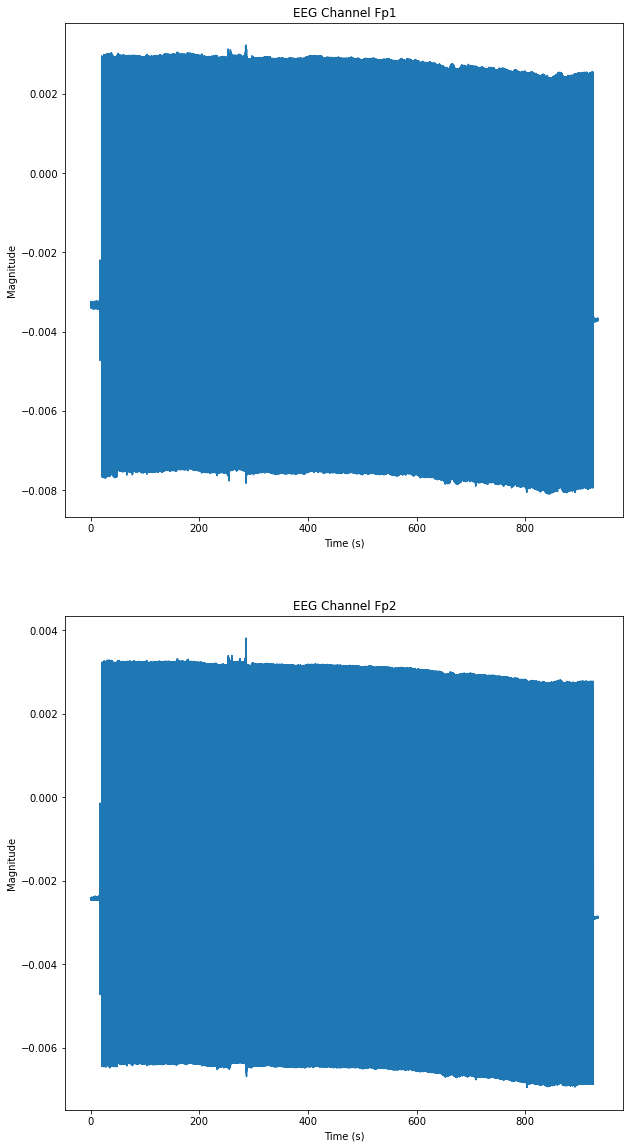

In [5]:
# Plot first 8 channels using mne plotting feature
# pat1.plot(color='k', bad_color='r', n_channels=8)

# Plot just FP1 and FP2
fig, ax = plt.subplots(2,1, figsize = (10,20))
for i in range(2):
    ax[i].plot(times, data[i])
    ax[i].set_title('EEG Channel Fp{}'.format(i+1))
    ax[i].set_ylabel('Magnitude')
    ax[i].set_xlabel('Time (s)')
plt.show()


In [6]:
# Read in tsv file to obtain sleep stage classification data
with open('sourcedata_sub-01-sleep-stage.tsv') as file:
    tsv_pat1 = csv.reader(file, delimiter='\t')    

    run_1_stages = []
    for line in tsv_pat1:
        if line[1] == 'task-sleep_run-1':
            run_1_stages.append(line[3])
        
print(run_1_stages) # sleep stage classification score for each epoch in sleep_run-1

# Next: Take DTFT of FP1 and/or FP2 channels, classify sleep stages by dominant frequency and compare to these classification scores

['2', '2', '1', '1', '1', '2', '1', '1', '1', '1', 'W', '1', '1', '1', '1', '1', 'W', 'W', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '1']


In [7]:
# FT Function from Lab 10

def ExploreFTplots(hn, zeropad, FS):
    '''
    Inputs:
    hn: 1D input signal
    zeropad: number of zero padding to the right side of hn
    FS: sampling frequency in Hz
    
    fvec - > 1D Vector specify the frequency domain
    FTOutput - > Fourier Transform result with DC centered in the middle of the array
    
    '''
    # do padding
    zeropaddedhn = np.pad(hn, zeropad)
    
    # construct fvec with given function inputs
    fvec= np.linspace(-FS/2, FS/2, len(zeropaddedhn))
    
    # compute the fft result
    fft_result = np.fft.fft(zeropaddedhn)
    
    # perform the fft shift so that DC is centered in the resulting array
    FTOutput = np.fft.fftshift(fft_result)

    return fvec, FTOutput

# FT plotting function
def FTplot(fvec, FT, name):
    ft_mag = np.abs(FT)
    fvec_size = np.round(np.max(fvec), 0)
    plt.plot(fvec, ft_mag)
    plt.title('{} FFT - {} Hz'.format(name, fvec_size))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

(4670200,) (4670200,)


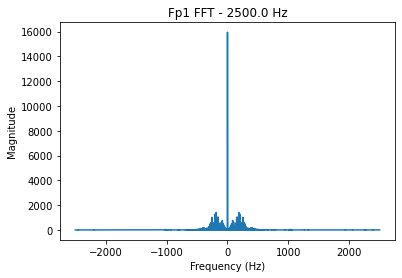

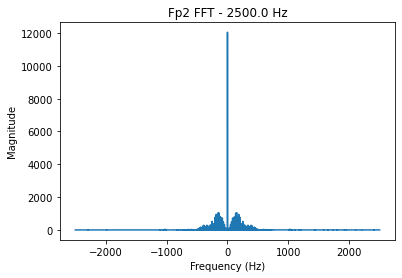

In [8]:
# Look at Fp1 and Fp2
fp1 = data[0]
fp2 = data[1]
print(fp1.shape, fp2.shape)

# FT of Fp1 and Fp2
fvec, fp1_FT = ExploreFTplots(fp1, 0, fs)
fvec, fp2_FT = ExploreFTplots(fp2, 0, fs)
FTplot(fvec, fp1_FT, 'Fp1')
FTplot(fvec, fp2_FT, 'Fp2')


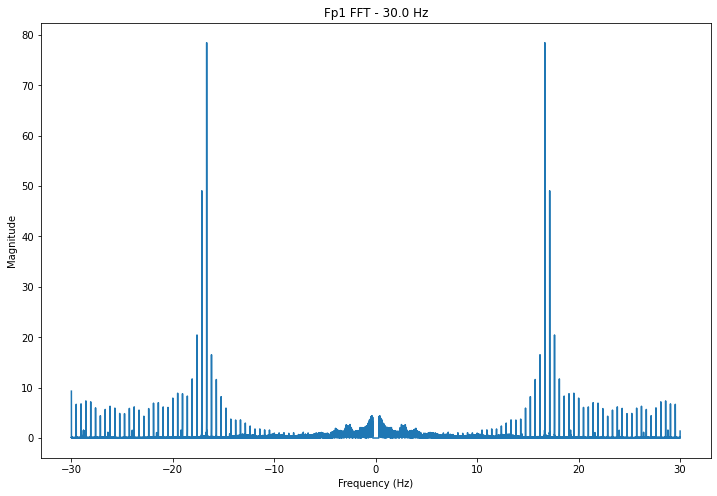

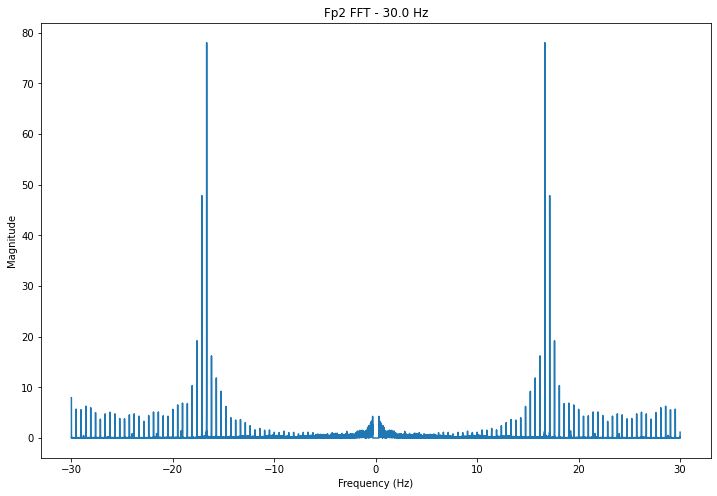

In [14]:
# BPF from 0.3-30 Hz and reassess 
BPF = ((np.abs(fvec)<=30) & (np.abs(fvec)>=0.3))*1 # using fvec from latest run of FT function
fp1_BPF = BPF*fp1_FT
fp2_BPF = BPF*fp2_FT


df1 = pd.DataFrame(data = {'fvec': fvec, 'FT': fp1_BPF})
df2 = pd.DataFrame(data = {'fvec': fvec, 'FT': fp2_BPF})
df1_new = df1[abs(df1['fvec']) <= 30]
df2_new = df2[abs(df2['fvec']) <= 30]

FTplot(df1_new['fvec'].values, df1_new['FT'].values, 'Fp1')
FTplot(df2_new['fvec'].values, df2_new['FT'].values, 'Fp2')

C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


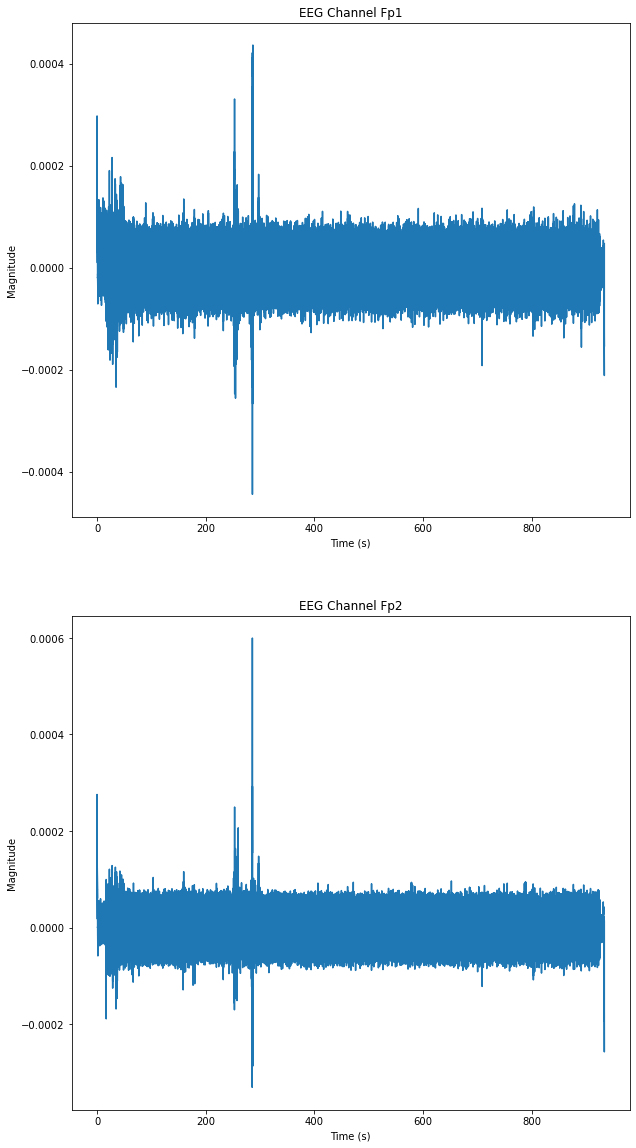

In [11]:
# IFFT to show filtered signal in time domain
fp1_time = np.fft.ifft(np.fft.fftshift(fp1_BPF))
fp2_time = np.fft.ifft(np.fft.fftshift(fp2_BPF))
time_fp = [fp1_time, fp2_time]

fig, ax = plt.subplots(2,1, figsize = (10,20))
for i in range(2):
    ax[i].plot(times, time_fp[i])
    ax[i].set_title('EEG Channel Fp{}'.format(i+1))
    ax[i].set_ylabel('Magnitude')
    ax[i].set_xlabel('Time (s)')
plt.show()

Zxx.shape: (150000, 64)


C:\Users\brade\AppData\Local\Temp\ipykernel_14260\2785231969.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(t, f, abs(Zxx))


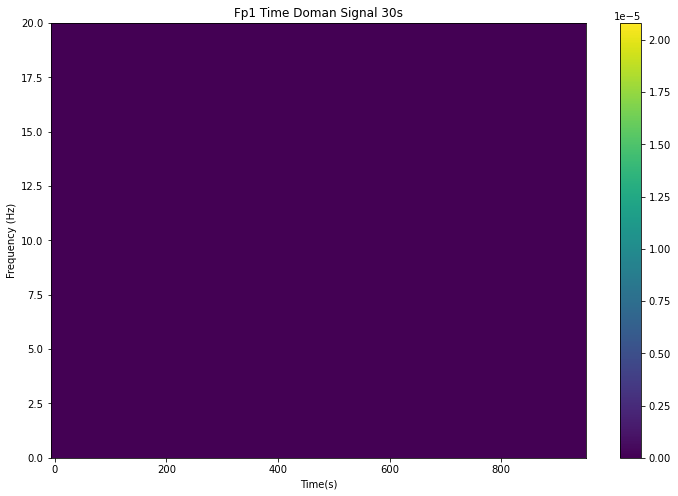

In [17]:
# STFT of our Fp1 EEG data using 30 sec windows to match OpenNeuro data windows
fs = 5000
duration = 30
nperseg = fs*duration
f, t, Zxx = signal.stft(fp2_time, fs, nperseg=nperseg, nfft=None)
print('Zxx.shape:', Zxx.shape)

plt.rcParams['figure.figsize'] = [12,8]
plt.pcolormesh(t, f, np.log(abs(Zxx)))
plt.title('Fp1 Time Doman Signal {}s'.format(duration));
plt.xlabel('Time(s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0,20)
plt.colorbar()
plt.show()

C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


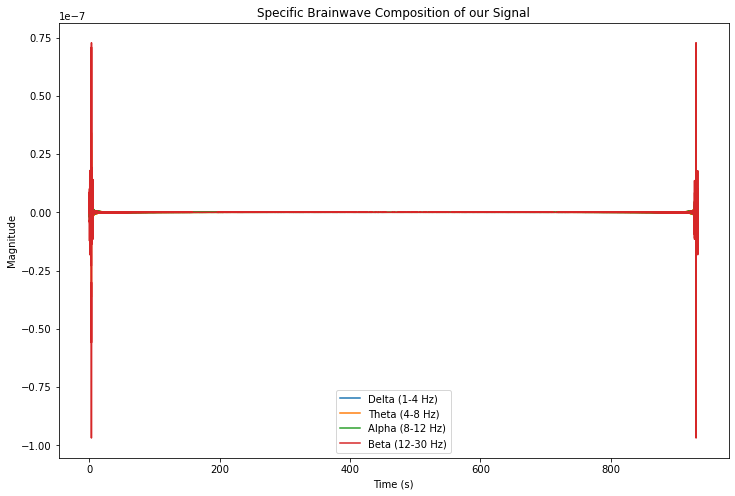

In [19]:
# Use BPF for each sleep stage freq range to calculate power in time
alpha_BPF = ((np.abs(fvec)<=12) & (np.abs(fvec)>=8))
delta_BPF = ((np.abs(fvec)<=4) & (np.abs(fvec)>=1))
theta_BPF = ((np.abs(fvec)<=8) & (np.abs(fvec)>=4))
beta_BPF = ((np.abs(fvec)<=30) & (np.abs(fvec)>=12))

alpha_FT = fp1_time*alpha_BPF
alpha_time = np.fft.ifft(np.fft.fftshift(alpha_FT))

delta_FT = fp1_time*delta_BPF
delta_time = np.fft.ifft(np.fft.fftshift(delta_FT))

theta_FT = fp1_time*theta_BPF
theta_time = np.fft.ifft(np.fft.fftshift(theta_FT))

beta_FT = fp1_time*beta_BPF
beta_time = np.fft.ifft(np.fft.fftshift(beta_FT))

plt.plot(times, delta_time, label='Delta (1-4 Hz)')
plt.plot(times, theta_time, label='Theta (4-8 Hz)')
plt.plot(times, alpha_time, label='Alpha (8-12 Hz)')
plt.plot(times, beta_time, label='Beta (12-30 Hz)')
plt.title('Specific Brainwave Composition of our Signal')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.legend()
plt.show()